In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import wandb
import torch.fft
import seaborn as sns
from tqdm import tqdm
from numpy.polynomial.legendre import legval
from scipy.special import comb
from scipy.special import gamma

In [2]:
from src import Solver
from src import pdeOperator , OperatorConfig
from src import LpLoss, VariationalLoss
from src import BoundaryCondition, BoundaryLoss, BoundaryType, BoundaryLocation
from src import PINN_Net
from src.Training.trainer import Trainer

In [3]:
file_path = r"C:\Users\mohammed\OneDrive\Documents\QFM -S2\Solving PDE's using ANN\Solving-PDE-s-using-neural-network\trained_models\v1.0\model.pt"
AW_filepath = r"C:\Users\mohammed\OneDrive\Documents\QFM -S2\Solving PDE's using ANN\Solving-PDE-s-using-neural-network\trained_models\v1.1\model.pt"
AC_filepath = r"C:\Users\mohammed\OneDrive\Documents\QFM -S2\Solving PDE's using ANN\Solving-PDE-s-using-neural-network\trained_models\v1.2\model.pt"
AWAC_filepath = r"C:\Users\mohammed\OneDrive\Documents\QFM -S2\Solving PDE's using ANN\Solving-PDE-s-using-neural-network\trained_models\v1.3\model.pt"
state_dict = torch.load(file_path)
AWstate_dict = torch.load(AW_filepath)
ACstate_dict = torch.load(AC_filepath)
AWACstate_dict = torch.load(AWAC_filepath)

model = PINN_Net(1 , 1 , 100 , 2)
AW_model = PINN_Net(1 , 1 , 100 , 2)
AC_model = PINN_Net(1 , 1 , 100 , 2)
AWAC_model = PINN_Net(1 , 1 , 100 , 2)

model.load_state_dict(state_dict)
AW_model.load_state_dict(AWstate_dict)
AC_model.load_state_dict(ACstate_dict)
AWAC_model.load_state_dict(AWACstate_dict)

C:\Users\mohammed\AppData\Local\Temp\ipykernel_15000\3785843838.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(file_path)
C:\Users\mohammed\AppD

<All keys matched successfully>

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

d = pdeOperator()

R = 1.0  # radius
coords = [torch.linspace(-R, R, 10)] 

# Define operator for Poiseuille flow
operator = lambda u, x: d.derivative(u, x, order=2) 

# Source term (not directly used in Poiseuille Flow)
f = lambda x: (-1.6 * (torch.pi**2) * torch.sin(torch.pi * x * 4) - 50 * torch.tanh(5 * x) * (1 - torch.tanh(5 * x)**2))

u_exact = lambda x: 0.1*torch.sin(torch.pi*x*4) + torch.tanh(5*x) 



In [5]:
import numpy as np
lploss = LpLoss(d=1, p=1, reduction='mean')
v_loss = VariationalLoss(dim=1, dx=1/32, reduction="mean" , integration_method="simpson")

def l2_error(pred, true):
    return torch.sqrt(torch.sum((pred - true) ** 2))/torch.sqrt(torch.sum(true**2))

solver = Solver(hidden_size=100, num_layers=1, learning_rate=0.01, device=None, wandb_logs=False, name=None)
TF = False


pde_configurations = OperatorConfig(
            operator=operator,
            weight= torch.tensor(1.0),
            source_function=f,
            u_exact=u_exact,
            trainable=TF,
            weight_function= lambda x: torch.exp(-x),
            pde_loss = l2_error,
            adaptive_nodes = 0,
            update_rate = 50,

        )

bcs = [
        BoundaryCondition(
            type=BoundaryType.DIRICHLET,
            location=BoundaryLocation.X_MAX,    
            value= 1 ,
            weight=torch.tensor(0.0),
            trainable=TF,
            weight_function= lambda x: torch.exp(-x),

        ),
        
        BoundaryCondition(
            type=BoundaryType.DIRICHLET,
            location=BoundaryLocation.X_MIN,
            value=-1,
            weight=torch.tensor(0.0),
            trainable=TF,
            weight_function = lambda x: torch.exp(-x) ,
        )
    ]

MSE = []
Loss = []


model, mse, loss, new_coords, risid = solver.solve(
    dimensions=1, epochs=2000, coords=coords,
    pde_configurations=pde_configurations, boundary_conditions=bcs
) 


Training:   0%|          | 3/2000 [00:00<01:24, 23.71epoch/s, Loss=5.6067e-01, MSE=4.2770e-01]

Training the model...


Training: 100%|██████████| 2000/2000 [00:25<00:00, 77.39epoch/s, Loss=7.0280e-04, MSE=2.5624e-01] 


In [280]:
for i in range(1):
    pde_configurations = OperatorConfig(
                operator=operator,
                weight= torch.tensor(PDE),
                source_function=f,
                u_exact=u_exact,
                trainable=TF,
                weight_function= lambda x: torch.exp(-x),
                pde_loss = l2_error,
                adaptive_nodes = 0,
                update_rate = 50,

            )

    bcs = [
            BoundaryCondition(
                type=BoundaryType.DIRICHLET,
                location=BoundaryLocation.X_MAX,    
                value= 1 ,
                weight=torch.tensor(B1.weight),
                trainable=TF,
                weight_function= lambda x: torch.exp(-x),

            ),
            
            BoundaryCondition(
                type=BoundaryType.DIRICHLET,
                location=BoundaryLocation.X_MIN,
                value=-1,
                weight=torch.tensor(B2.weight),
                trainable=TF,
                weight_function = lambda x: torch.exp(-x) ,
            )
        ]


    # Create a new solver for each iteration
    solver = Solver(hidden_size=100, num_layers=1, learning_rate=0.01, device=None, wandb_logs=False, name=None)

    # Solve with a fresh model instance
    model, mse, loss, new_coords, risid = solver.solve(
        dimensions=1, epochs=1000, coords=coords,
        pde_configurations=pde_configurations, boundary_conditions=bcs
    )  
    
    MSE.append(mse)
    Loss.append(loss)
    print(f"Iteration {i+1}: MSE={mse}, Loss={loss}")

print(f"avergae MSE: {np.mean(MSE)}")
print(f"avergae Loss: {np.mean(Loss)}")
print(f"std MSE: {np.std(MSE)}")
print(f"std Loss: {np.std(Loss)}")

C:\Users\mohammed\AppData\Local\Temp\ipykernel_9556\1510791968.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weight= torch.tensor(PDE),
C:\Users\mohammed\AppData\Local\Temp\ipykernel_9556\1510791968.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weight=torch.tensor(B1.weight),
C:\Users\mohammed\AppData\Local\Temp\ipykernel_9556\1510791968.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weight=torch.tensor(B2.weight),
Training:   1%|          | 11/1000 [00:00<00:09, 107.69epoch/s, Loss=9.1334e-03, MSE=2.0620e-01]

Training the model...


Training: 100%|██████████| 1000/1000 [00:07<00:00, 129.02epoch/s, Loss=7.2762e-06, MSE=1.0641e-01]

Iteration 1: MSE=0.10640767216682434, Loss=7.276206360984361e-06
avergae MSE: 0.10640767216682434
avergae Loss: 7.276206360984361e-06
std MSE: 0.0
std Loss: 0.0


In [287]:
B1 = bcs[0]
B2 = bcs[1]
PDE = pde_configurations.weight

print(f"BC1: {B1.weight} weight function: {torch.exp(-B2.weight)}")
print(f"BC2: {B2.weight} weight function: {torch.exp(-B2.weight)}")
print(f"PDE: {PDE} weight function: {torch.exp(-PDE)}")




BC1: 2.225917339324951 weight function: 0.09830567240715027
BC2: 2.319673538208008 weight function: 0.09830567240715027
PDE: 11.81546401977539 weight function: 7.389399797830265e-06


## PINN

avergae MSE: 0.04697772059589624
avergae Loss: 0.00042138767921126856
std MSE: 0.023411508672715794
std Loss: 0.0008837540918419517

In [318]:
x = torch.linspace(-1 , 1 , 10 , requires_grad=True)

model = PINN_Net(1, 1, 100, 1)
weights = [torch.tensor(1.0 , requires_grad= True) for _ in range(3)]
#optimizer = torch.optim.Adam([{'params': model.parameters()}, {'params': weights}], lr=0.01)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.1)

for epoch in range(2000):
    optimizer.zero_grad()
    u_pred = model(x.unsqueeze(1))
    bc_loss1 = l2_error(u_pred[0], torch.tensor(-1.0).unsqueeze(0))
    bc_loss2 = l2_error(u_pred[-1], torch.tensor(1.0).unsqueeze(0))
    pde_loss = l2_error(d.derivative(u_pred, x, order=2), f(x))
    #loss = torch.exp(-weights[0])*bc_loss1 + torch.exp(-weights[1])*bc_loss2 + torch.exp(-weights[2])*pde_loss #+ torch.abs(weights[0]) + torch.abs(weights[1]) + torch.abs(weights[2])
    #loss = (torch.abs(weights[0])/sum([torch.abs(w) for w in weights]))*bc_loss1 + (torch.abs(weights[1])/sum([torch.abs(w) for w in weights]))*bc_loss2 + (torch.abs(weights[2])/sum([torch.abs(w) for w in weights]))*pde_loss
    loss = (bc_loss1 + bc_loss2 + pde_loss)*0.3
    loss.backward(retain_graph=True)
    optimizer.step()
    scheduler.step()

    if epoch % 100 == 0:
        print(f"epoch: {epoch} , loss: {loss.item()} , bc1: {bc_loss1.item()} , bc2: {bc_loss2.item()} , pde: {pde_loss.item()}")
        #print(f"weights: {torch.exp(-weights[0]) , torch.exp(-weights[1]) , torch.exp(-weights[2])}")
        #print(f"weights: {weights[0].item() , weights[1].item() , weights[2].item()}")




epoch: 0 , loss: 0.9931966662406921 , bc1: 1.297739028930664 , bc2: 1.0131018161773682 , pde: 0.9998144507408142
epoch: 100 , loss: 0.20363014936447144 , bc1: 0.0047425031661987305 , bc2: 0.017674565315246582 , pde: 0.6563500761985779
epoch: 200 , loss: 0.10957089066505432 , bc1: 0.017461121082305908 , bc2: 0.08455514907836914 , pde: 0.26322001218795776
epoch: 300 , loss: 0.06994137912988663 , bc1: 0.06975245475769043 , bc2: 0.01155620813369751 , pde: 0.15182925760746002
epoch: 400 , loss: 0.05610573664307594 , bc1: 0.037578046321868896 , bc2: 0.050061583518981934 , pde: 0.09937947243452072
epoch: 500 , loss: 0.018074525520205498 , bc1: 0.0016478896141052246 , bc2: 0.016520261764526367 , pde: 0.042080264538526535
epoch: 600 , loss: 0.005039406009018421 , bc1: 0.0051190853118896484 , bc2: 0.004721999168395996 , pde: 0.006956933997571468
epoch: 700 , loss: 0.0010267492616549134 , bc1: 0.0005213022232055664 , bc2: 0.0012331604957580566 , pde: 0.0016680345870554447
epoch: 800 , loss: 0.002

In [84]:
import torch
import copy

def create_finetuning_model(original_model, learning_rate=0.01):
    """Create copy of model for fine-tuning"""
    
    # Deep copy model and weights
    model_finetune = copy.deepcopy(original_model)
    
    # Create new optimizer
    optimizer = torch.optim.Adam(model_finetune.parameters(), lr=learning_rate)
    
    # Create scheduler
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 
                                              step_size=100, 
                                              gamma=0.5)
    
    return model_finetune, optimizer, scheduler

# Usage
model_ft, optimizer_ft, scheduler_ft = create_finetuning_model(model , learning_rate=8e-3)

# Verify weights are copied but separate
print("Original model first parameter:", 
      next(model.parameters())[0,0])
print("Fine-tune model first parameter:", 
      next(model_ft.parameters())[0,0])


model_ft2 = PINN_Net(1, 1, 100, 1)
optimizer_ft2 = torch.optim.Adam(model_ft2.parameters(), lr=0.01)
scheduler_ft2 = torch.optim.lr_scheduler.StepLR(optimizer_ft2, step_size=500, gamma=0.1)




for epoch in range(2000):
    optimizer_ft.zero_grad()
    #feature = model(x.unsqueeze(1))
    u_pred = model_ft(x.unsqueeze(1))
    loss = F.mse_loss(operator(u_pred, x), f(x)) + F.mse_loss(u_pred[-1], torch.tensor(-1.0).unsqueeze(0)) + F.mse_loss(u_pred[0],  torch.tensor(1.0).unsqueeze(0))
    loss.backward(retain_graph=True)
    optimizer_ft.step()
    scheduler_ft.step()

    if epoch % 100 == 0:
        print(f"epoch: {epoch} , loss: {loss.item()}")


Original model first parameter: tensor(-0.2654, grad_fn=<SelectBackward0>)
Fine-tune model first parameter: tensor(-0.2654, grad_fn=<SelectBackward0>)
epoch: 0 , loss: 2.363816976547241
epoch: 100 , loss: 0.009187692776322365
epoch: 200 , loss: 0.004503218457102776
epoch: 300 , loss: 0.003174570854753256
epoch: 400 , loss: 0.0026313522830605507
epoch: 500 , loss: 0.0023783736396580935
epoch: 600 , loss: 0.002251447644084692
epoch: 700 , loss: 0.0021852627396583557
epoch: 800 , loss: 0.002150018932297826
epoch: 900 , loss: 0.002131232526153326
epoch: 1000 , loss: 0.0021211004350334406
epoch: 1100 , loss: 0.0021156419534236193
epoch: 1200 , loss: 0.002112752292305231
epoch: 1300 , loss: 0.0021112330723553896
epoch: 1400 , loss: 0.00211047800257802
epoch: 1500 , loss: 0.002110135741531849
epoch: 1600 , loss: 0.002110004425048828
epoch: 1700 , loss: 0.0021100144367665052
epoch: 1800 , loss: 0.0021099860314279795
epoch: 1900 , loss: 0.002109979745000601


l2 error: 0.000702186138369143
mse error: 3.895040947554662e-07
boundary 1 : 0.0010559518123045564
boundary 1 mse loss: 1.1124009233753895e-06
boundary 2 : 0.0010472789872437716
boundary 2 mse loss: 1.0933720204775454e-06
l2 error: 0.1156948059797287
mse error: 0.010573900304734707
boundary 1 : 0.0006297518848441541
boundary 1 mse loss: 3.9565082943227026e-07
boundary 2 : 0.0011647642822936177
boundary 2 mse loss: 1.3524439737011562e-06
l2 error: 0.000702186138369143
mse error: 3.895040947554662e-07
boundary 1 : 0.0010559518123045564
boundary 1 mse loss: 1.1124009233753895e-06
boundary 2 : 0.0010472789872437716
boundary 2 mse loss: 1.0933720204775454e-06
l2 error: 0.00273011508397758
mse error: 5.888022315048147e-06
boundary 1 : 0.0001553940965095535
boundary 1 mse loss: 2.4090297756629298e-08
boundary 2 : 0.00015730377344880253
boundary 2 mse loss: 2.4667290432489608e-08


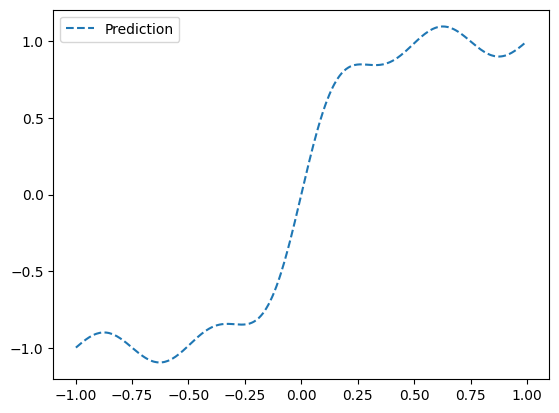

In [33]:
y = torch.linspace(-1, 1 , 1000)
y = torch.rand(1000) * 2 - 1
y = torch.sort(y).values
f_exact = (-1.6 * (torch.pi**2) * torch.sin(torch.pi * y * 4) - 50 * torch.tanh(5 * y) * (1 - torch.tanh(5 * y)**2))
f_exact = (f_exact - f_exact.max())/(f_exact.max() - f_exact.min())
u_pred = AC_model_2D(y.unsqueeze(1))
AW_u_pred = AW_model(y.unsqueeze(1))
AC_u_pred = AC_model(y.unsqueeze(1))
ACAW_u_pred_2 = AWAC_model(y.unsqueeze(1))
exact = u_exact(y.unsqueeze(-1))



#l2 = lploss(u_pred, exact)
#print(f"L2 error: {l2}")

#model1
print(f"l2 error: {l2_error(u_pred, exact)}")
print(f"mse error: {F.mse_loss(u_pred, exact)}")
print(f"boundary 1 : {l2_error(u_pred[-1], exact[-1])}")
print(f"boundary 1 mse loss: {F.mse_loss(u_pred[-1], exact[-1])}")
print(f"boundary 2 : {l2_error(u_pred[0], exact[0])}")
print(f"boundary 2 mse loss: {F.mse_loss(u_pred[0], exact[0])}")
#model2
print(f"l2 error: {l2_error(AW_u_pred, exact)}")
print(f"mse error: {F.mse_loss(AW_u_pred, exact)}")
print(f"boundary 1 : {l2_error(AW_u_pred[-1], exact[-1])}")
print(f"boundary 1 mse loss: {F.mse_loss(AW_u_pred[-1], exact[-1])}")
print(f"boundary 2 : {l2_error(AW_u_pred[0], exact[0])}")
print(f"boundary 2 mse loss: {F.mse_loss(AW_u_pred[0], exact[0])}")
#model3
print(f"l2 error: {l2_error(AC_u_pred, exact)}")
print(f"mse error: {F.mse_loss(AC_u_pred, exact)}")
print(f"boundary 1 : {l2_error(AC_u_pred[-1], exact[-1])}")
print(f"boundary 1 mse loss: {F.mse_loss(AC_u_pred[-1], exact[-1])}")
print(f"boundary 2 : {l2_error(AC_u_pred[0], exact[0])}")
print(f"boundary 2 mse loss: {F.mse_loss(AC_u_pred[0], exact[0])}")
#model4
print(f"l2 error: {l2_error(ACAW_u_pred_2, exact)}")
print(f"mse error: {F.mse_loss(ACAW_u_pred_2, exact)}")
print(f"boundary 1 : {l2_error(ACAW_u_pred_2[-1], exact[-1])}")
print(f"boundary 1 mse loss: {F.mse_loss(ACAW_u_pred_2[-1], exact[-1])}")
print(f"boundary 2 : {l2_error(ACAW_u_pred_2[0], exact[0])}")
print(f"boundary 2 mse loss: {F.mse_loss(ACAW_u_pred_2[0], exact[0])}")


plt.plot(y.cpu().detach().numpy().squeeze(), u_pred.cpu().detach().numpy().squeeze(), label="Prediction", linestyle="--")   
"""plt.plot(y.cpu().detach().numpy().squeeze(), AW_u_pred.cpu().detach().numpy().squeeze(), label="Prediction2", linestyle="--")
plt.plot(y.cpu().detach().numpy().squeeze(), AC_u_pred.cpu().detach().numpy().squeeze(), label="Prediction3", linestyle="--")
plt.plot(y.cpu().detach().numpy().squeeze(), ACAW_u_pred_2.cpu().detach().numpy().squeeze(), label="Prediction4", linestyle="--")
plt.plot(y.cpu().detach().numpy().squeeze(), u_exact(y).cpu().detach().numpy().squeeze(), label="Exact")"""
#plt.plot(y.cpu().detach().numpy().squeeze(), f_exact.cpu().detach().numpy().squeeze(), label="Source")
plt.legend()    
plt.show()

In [13]:
import pandas as pd
import numpy as np
import torch.nn.functional as F

def create_comparison_table(u_pred, AW_u_pred, AC_u_pred, ACAW_u_pred_2, exact):
    metrics = {
        'Metric': ['L2 Error', 'MSE Error', 
                  'Boundary 1 L2', 'Boundary 1 MSE',
                  'Boundary 2 L2', 'Boundary 2 MSE'],
        'PINN': [
            l2_error(u_pred, exact).item(),
            F.mse_loss(u_pred, exact).item(),
            l2_error(u_pred[-1], exact[-1]).item(),
            F.mse_loss(u_pred[-1], exact[-1]).item(),
            l2_error(u_pred[0], exact[0]).item(),
            F.mse_loss(u_pred[0], exact[0]).item()
        ],
        'AW-PINN': [
            l2_error(AW_u_pred, exact).item(),
            F.mse_loss(AW_u_pred, exact).item(),
            l2_error(AW_u_pred[-1], exact[-1]).item(),
            F.mse_loss(AW_u_pred[-1], exact[-1]).item(),
            l2_error(AW_u_pred[0], exact[0]).item(),
            F.mse_loss(AW_u_pred[0], exact[0]).item()
        ],
        'AC-PINN': [
            l2_error(AC_u_pred, exact).item(),
            F.mse_loss(AC_u_pred, exact).item(),
            l2_error(AC_u_pred[-1], exact[-1]).item(),
            F.mse_loss(AC_u_pred[-1], exact[-1]).item(),
            l2_error(AC_u_pred[0], exact[0]).item(),
            F.mse_loss(AC_u_pred[0], exact[0]).item()
        ],
        'ACAW-PINN': [
            l2_error(ACAW_u_pred_2, exact).item(),
            F.mse_loss(ACAW_u_pred_2, exact).item(),
            l2_error(ACAW_u_pred_2[-1], exact[-1]).item(),
            F.mse_loss(ACAW_u_pred_2[-1], exact[-1]).item(),
            l2_error(ACAW_u_pred_2[0], exact[0]).item(),
            F.mse_loss(ACAW_u_pred_2[0], exact[0]).item()
        ]
    }
    
    df = pd.DataFrame(metrics)
    df = df.set_index('Metric')
    
    styled_df = df.style.format({
        'PINN': '{:.2e}',
        'AW-PINN': '{:.2e}',
        'AC-PINN': '{:.2e}',
        'ACAW-PINN': '{:.2e}'
    })
    
    return styled_df

# Usage
comparison = create_comparison_table(u_pred, AW_u_pred, AC_u_pred, ACAW_u_pred_2, exact)
display(comparison)

,PINN,AW-PINN,AC-PINN,ACAW-PINN
Metric,,,,
L2 Error,4.42e-01,1.15e-01,6.83e-04,2.73e-03
MSE Error,1.55e-01,1.05e-02,3.71e-07,5.93e-06
Boundary 1 L2,5.26e-04,4.29e-04,1.06e-03,1.57e-04
Boundary 1 MSE,2.76e-07,1.84e-07,1.11e-06,2.46e-08
Boundary 2 L2,7.01e-04,4.26e-03,1.05e-03,1.88e-04
Boundary 2 MSE,4.86e-07,1.79e-05,1.08e-06,3.50e-08


In [5]:
pde_configurations = OperatorConfig(
            operator=operator,
            weight= torch.tensor(1.0),
            source_function=f,
            u_exact=u_exact,
            trainable=True,
            weight_function= lambda x: torch.abs(-x),
            pde_loss = F.mse_loss,
            adaptive_nodes = 0,
            update_rate = 100,

        )

bcs = [
        BoundaryCondition(
            type=BoundaryType.DIRICHLET,
            location=BoundaryLocation.X_MAX,
            value= torch.tensor(1.0),
            weight=torch.tensor(1.0),
            trainable=True,
            weight_function= lambda x: torch.exp(-x),

        ),
        
        BoundaryCondition(
            type=BoundaryType.DIRICHLET,
            location=BoundaryLocation.X_MIN,
            value= torch.tensor(-1.0),
            weight=torch.tensor(1.0),
            trainable=True,
            weight_function = lambda x: torch.exp(-x) ,
        )
    ]



coords = [torch.linspace(-R, R, 12)] 
model , mse , loss , coords , risid = solver.solve(dimensions = 1, coords = coords, pde_configurations = pde_configurations, boundary_conditions = bcs, epochs = 3000 ) 

print(mse , loss)

Training:   0%|          | 4/3000 [00:00<01:16, 39.03epoch/s, Loss=2.4194e+02, MSE=1.5135e-01]

Training the model...


Training: 100%|██████████| 3000/3000 [00:29<00:00, 101.27epoch/s, Loss=2.8266e-02, MSE=1.4703e-01]


0.14702999591827393 0.02826612815260887


In [6]:
pde_configurations = OperatorConfig(
            operator=operator,
            weight= torch.tensor(1.0),
            source_function=f,
            u_exact=u_exact,
            trainable=False,
            weight_function= lambda x: torch.abs(-x),
            pde_loss = F.mse_loss,
            adaptive_nodes = 10,
            update_rate = 100,

        )

bcs = [
        BoundaryCondition(
            type=BoundaryType.DIRICHLET,
            location=BoundaryLocation.X_MAX,
            value= torch.tensor(1.0),
            weight=torch.tensor(1.0),
            trainable=False,
            weight_function= lambda x: torch.exp(-x),

        ),
        
        BoundaryCondition(
            type=BoundaryType.DIRICHLET,
            location=BoundaryLocation.X_MIN,
            value= torch.tensor(-1.0),
            weight=torch.tensor(1.0),
            trainable=False,
            weight_function = lambda x: torch.exp(-x) ,
        )
    ]


coords = [torch.linspace(-R, R, 12)] 
model , mse , loss , coords , risid = solver.solve(dimensions = 1, coords = coords, pde_configurations = pde_configurations, boundary_conditions = bcs, epochs = 3000 ,plot = False ) 


Training:   0%|          | 1/3000 [00:00<06:00,  8.33epoch/s, Loss=2.4726e+02, MSE=6.1352e-01]

Training the model...


Training: 100%|██████████| 3000/3000 [01:01<00:00, 48.86epoch/s, Loss=1.8556e-02, MSE=1.3541e-02]


In [7]:
pde_configurations = OperatorConfig(
            operator=operator,
            weight= torch.tensor(1.0),
            source_function=f,
            u_exact=u_exact,
            trainable=True,
            weight_function= lambda x: torch.exp(-x),
            pde_loss = F.mse_loss,
            adaptive_nodes = 10,
            update_rate = 200,

        )

bcs = [
        BoundaryCondition(
            type=BoundaryType.DIRICHLET,
            location=BoundaryLocation.X_MAX,
            value= torch.tensor(1.0),
            weight=torch.tensor(1.0),
            trainable=True,
            weight_function= lambda x: torch.exp(-x),

        ),
        
        BoundaryCondition(
            type=BoundaryType.DIRICHLET,
            location=BoundaryLocation.X_MIN,
            value= torch.tensor(-1.0),
            weight=torch.tensor(1.0),
            trainable=True,
            weight_function = lambda x: torch.exp(-x)  ,
        )
    ]


coords = [torch.linspace(-R, R, 12)] 
model , mse , loss , coords , risid = solver.solve(dimensions = 1, coords = coords, pde_configurations = pde_configurations, boundary_conditions = bcs, epochs = 500 ,plot = False ) 


Training:   0%|          | 0/500 [00:00<?, ?epoch/s]

Training the model...


Training:  42%|████▏     | 210/500 [00:05<00:03, 89.35epoch/s, Loss=1.5736e+01, MSE=1.2722e-01] 

torch.Size([22, 1])


Training:  82%|████████▏ | 409/500 [00:07<00:01, 83.84epoch/s, Loss=1.0184e-01, MSE=7.6892e-02] 

torch.Size([32, 1])


Training: 100%|██████████| 500/500 [00:08<00:00, 59.98epoch/s, Loss=1.6226e-02, MSE=2.1757e-02]


0.021756675094366074 0.016226286068558693


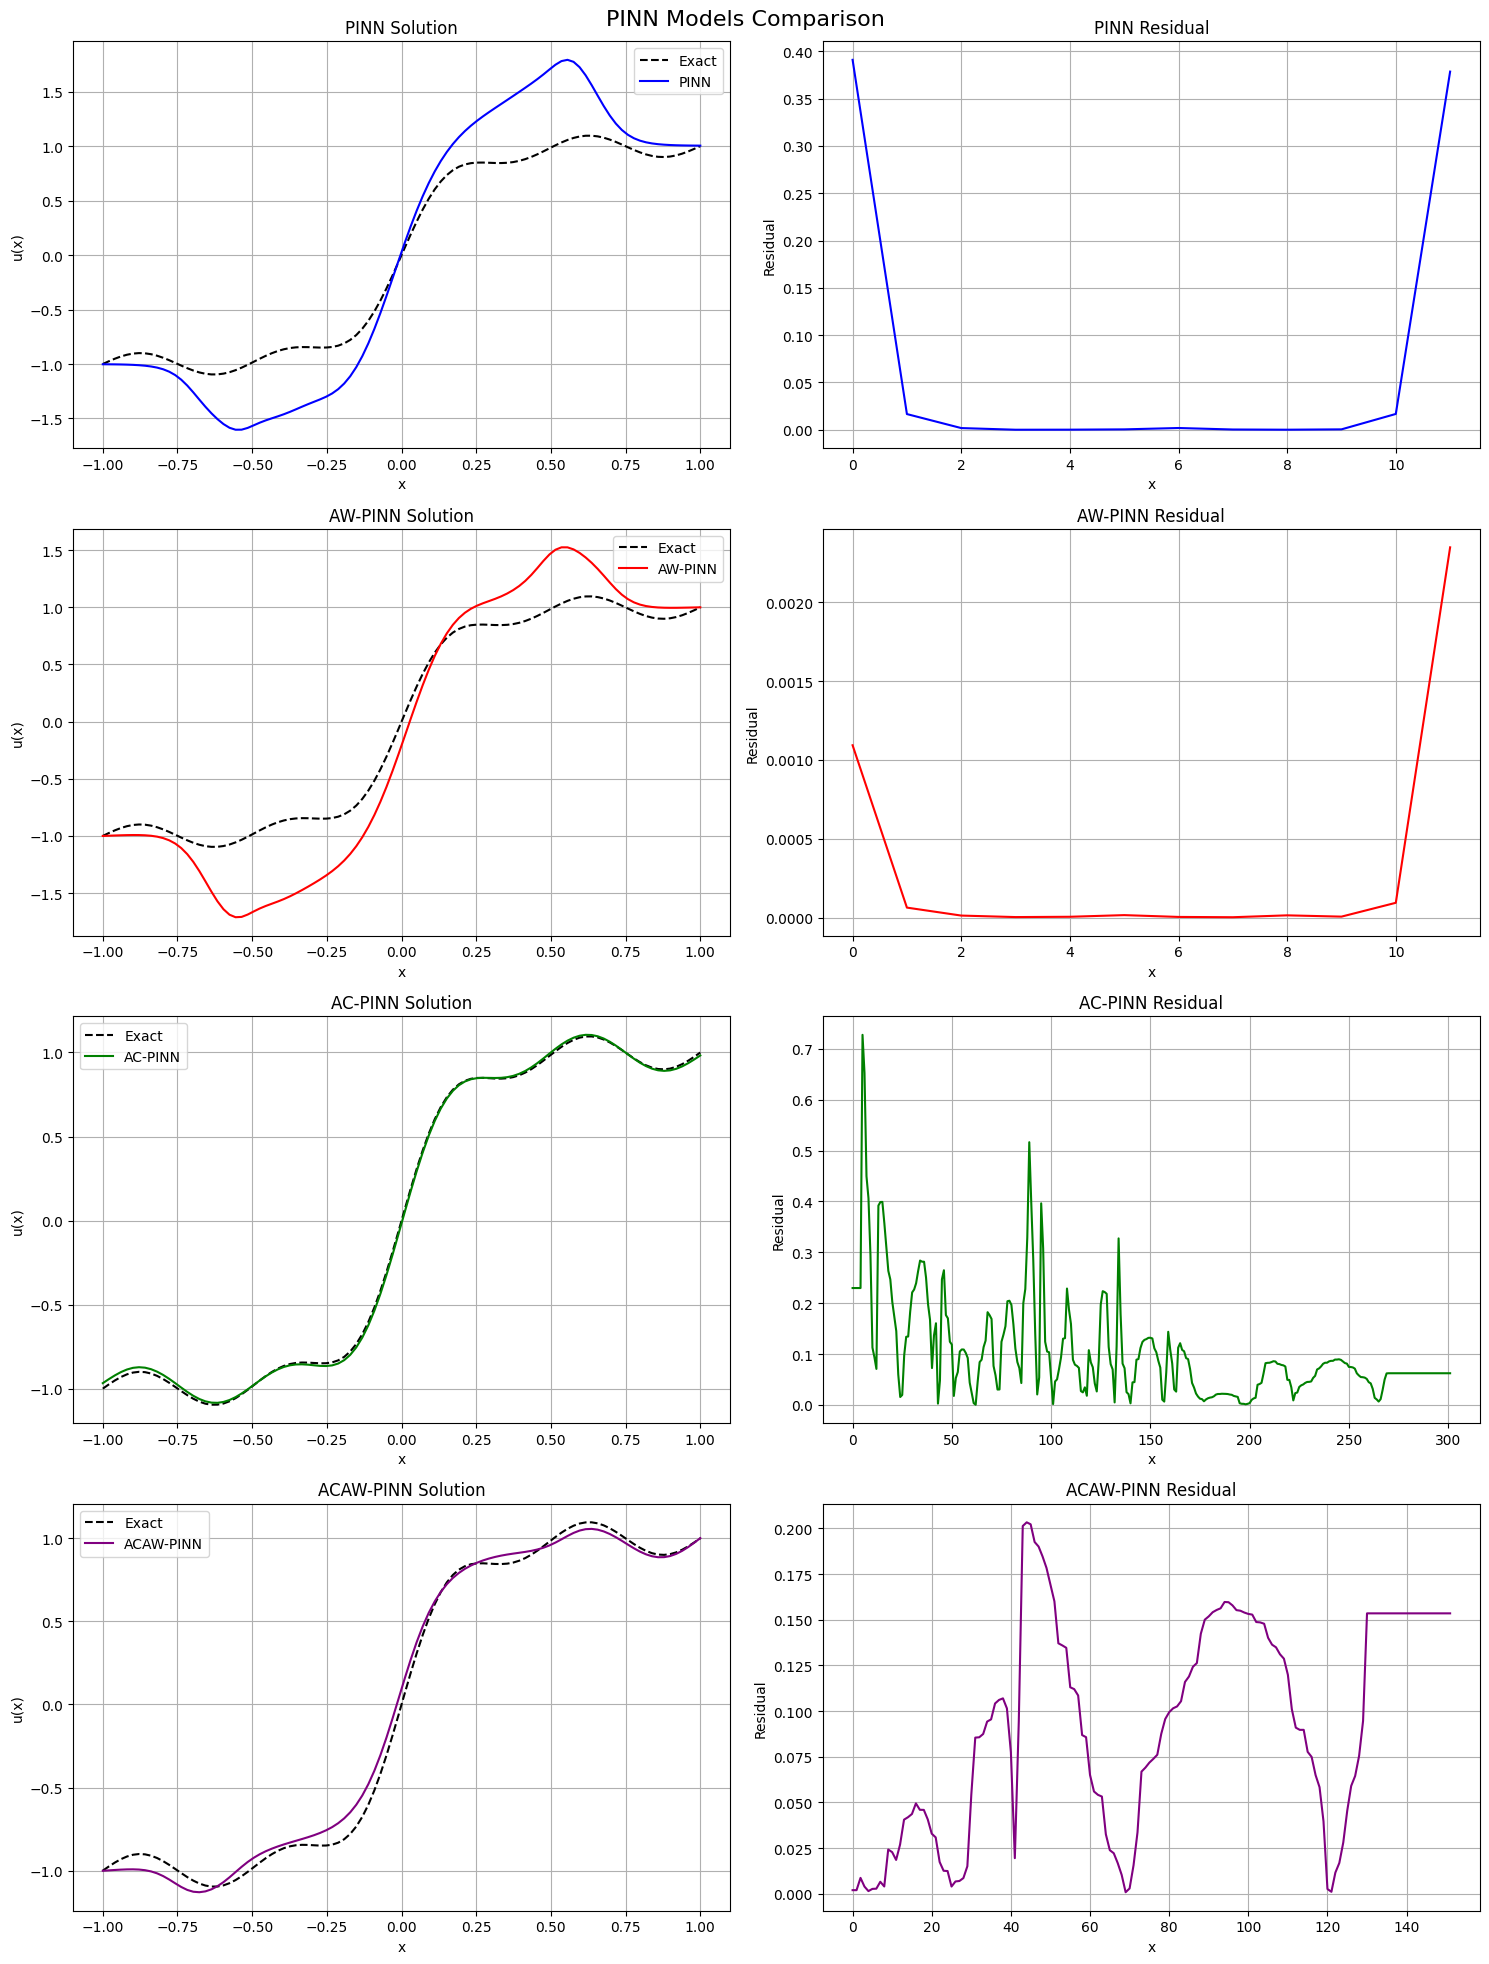

In [115]:
# all models
import matplotlib.pyplot as plt

def plot_1d_comparison(x, u_exact, models, residuals):
    """Plot solutions and residuals for PINN variants"""
    fig, axes = plt.subplots(4, 2, figsize=(15, 20))
    fig.suptitle('PINN Models Comparison', fontsize=16)
    
    model_names = ['PINN', 'AW-PINN', 'AC-PINN', 'ACAW-PINN']
    colors = ['b', 'r', 'g', 'purple']
    
    for idx, (name, model, resid) in enumerate(zip(model_names, models, residuals)):
        # Solution plot
        axes[idx, 0].plot(x, u_exact.detach().numpy(), 'k--', label='Exact')
        axes[idx, 0].plot(x, model(x.unsqueeze(1)).detach().numpy(), colors[idx], label=name)
        axes[idx, 0].set_title(f'{name} Solution')
        axes[idx, 0].set_xlabel('x')
        axes[idx, 0].set_ylabel('u(x)')
        axes[idx, 0].grid(True)
        axes[idx, 0].legend()
        
        # Residual plot
        axes[idx, 1].plot( resid.detach().numpy(), colors[idx])
        axes[idx, 1].set_title(f'{name} Residual')
        axes[idx, 1].set_xlabel('x')
        axes[idx, 1].set_ylabel('Residual')
        axes[idx, 1].grid(True)
        
    plt.tight_layout()
    plt.show()

# Usage
models = [PINN_model, AW_PINN_model, AC_PINN_model, ACAW_PINN_model]
residuals = [Pinn_risid, AW_Pinn_risid, AC_Pinn_risid, ACAW_Pinn_risid ]
plot_1d_comparison(x, u_exact(x), models, residuals)

## 2 Dimensions

In [29]:
domaine_2d = [-1,1,-1,1]
f_2d = lambda X,Y : torch.exp(-10*(X**2 + Y**2))*(-20)*(1-20*X**2) + torch.exp(-10*(X**2 + Y**2))*(-20)*(1-20*Y**2)
d = pdeOperator()
device = 'cpu'
operator_2d = lambda u,x,y : d.laplacian(u, x, y)
u_exact_2d = lambda x,y :  torch.exp(-10*(x**2 + y**2))
coords_2d = [torch.linspace(-1, 1, 10).to(device), torch.linspace(-1, 1, 10).to(device)]
solver = Solver(
        hidden_size=50,
        num_layers=2,
        learning_rate=0.01,
        device=None,
        wandb_logs=False,
        name=None
)

#lploss = LpLoss(d=2, p=1, size_average=True, reduction=True)
v_loss = VariationalLoss(dim=2, dx=1/16, reduction="sum" , integration_method="simpson")
u = u_exact_2d(*torch.meshgrid(coords_2d))      
boundary_conditions = [
        {'type': 'Dirichlet', 'location': 'y_max', 'value': u[:, -1]},
        {'type': 'Dirichlet', 'location': 'y_min', 'value': u[:, 0]},
        {'type': 'Dirichlet', 'location': 'x_min', 'value': u[0, :]},
        {'type': 'Dirichlet', 'location': 'x_max', 'value': u[-1, :]},
]
weight_function = lambda x: torch.exp(-x)
TF =False

pde_configurations = OperatorConfig(
            operator=operator_2d,
            weight= torch.tensor(1.0),
            source_function=f_2d,
            u_exact=u_exact_2d,
            trainable=TF,
            weight_function= weight_function,
            pde_loss = F.mse_loss,
            adaptive_nodes = 36,
            update_rate = 50,

        )

bcs = [
        BoundaryCondition(
                type=BoundaryType.DIRICHLET,
                location=BoundaryLocation.Y_MAX,
                value= lambda x,y : torch.exp(-10*(y[0,:]**2 + 1)).squeeze(),
                weight=1,
                trainable=TF,
                weight_function= weight_function,
                ),
        BoundaryCondition(
                type=BoundaryType.DIRICHLET,
                location=BoundaryLocation.Y_MIN,
                value= lambda x,y : torch.exp(-10*(y[0,:]**2 + 1)).squeeze(),
                weight=1,
                trainable=TF,
                weight_function= weight_function,


                ),
        BoundaryCondition(
                type=BoundaryType.DIRICHLET,
                location=BoundaryLocation.X_MIN,
                value= lambda x,y : torch.exp(-10*(1 + x[:,0]**2)).squeeze(),
                weight=1,
                trainable=TF,
                weight_function= weight_function,
                ),
        BoundaryCondition(
                type=BoundaryType.DIRICHLET,
                location=BoundaryLocation.X_MAX,
                value= lambda x,y : torch.exp(-10*(1 + x[:,0]**2)).squeeze(),
                weight=1,
                trainable=TF,
                weight_function= weight_function,
                )
]

adaptive_model , mse , loss , coords  , risid = solver.solve(dimensions = 2 ,
                                coords = coords_2d ,
                                boundary_conditions = bcs ,
                                pde_configurations=pde_configurations,
                                epochs = 1 ,
                                plot = False,
                                )
                                



print(mse , loss)

Training: 100%|██████████| 1/1 [00:00<00:00,  8.53epoch/s, Loss=9.2833e+00, MSE=2.4561e-01]

Training the model...
0.24561376869678497 9.283336639404297


In [40]:
lploss = LpLoss(d=2, p=1, reduction='mean')
x = torch.linspace(-1, 1, 500)
y = torch.linspace(-1, 1, 500)
X, Y = torch.meshgrid(x, y)
test_input = torch.cat((X.unsqueeze(-1), Y.unsqueeze(-1)), dim=-1)
u_pred = model(test_input)
u_exact = u_exact_2d(X, Y)
u_pred_adaptive = adaptive_model(test_input)
u_exact_adaptive = u_exact_2d(X, Y)
l2_adaptive = lploss(u_pred_adaptive.squeeze(), u_exact_adaptive.squeeze())
print(f"L2 error: {l2_adaptive}")
print(u_exact.shape, u_pred.shape)
l2 = lploss(u_pred.squeeze(), u_exact.squeeze())
print(f"L2 error: {l2}")

L2 error: 0.018978027626872063
torch.Size([500, 500]) torch.Size([500, 500, 1])
L2 error: 0.04692203924059868


In [34]:
file_path_2D = r"C:\Users\mohammed\OneDrive\Documents\QFM -S2\Solving PDE's using ANN\Solving-PDE-s-using-neural-network\trained_models\v1.10\model.pt"
AW_filepath_2D = r"C:\Users\mohammed\OneDrive\Documents\QFM -S2\Solving PDE's using ANN\Solving-PDE-s-using-neural-network\trained_models\v1.11\model.pt"
AC_filepath_2D = r"C:\Users\mohammed\OneDrive\Documents\QFM -S2\Solving PDE's using ANN\Solving-PDE-s-using-neural-network\trained_models\v1.12\model.pt"
AWAC_filepath_2D = r"C:\Users\mohammed\OneDrive\Documents\QFM -S2\Solving PDE's using ANN\Solving-PDE-s-using-neural-network\trained_models\v1.13\model.pt"
a_filepath = r"C:\Users\mohammed\OneDrive\Documents\QFM -S2\Solving PDE's using ANN\Solving-PDE-s-using-neural-network\trained_models\v1.13\model.pt"
state_dict_2D = torch.load(file_path_2D)
AWstate_dict_2D = torch.load(AW_filepath_2D)
ACstate_dict_2D = torch.load(AC_filepath_2D)
AWACstate_dict_2D = torch.load(AWAC_filepath_2D)

model_2D = PINN_Net(2 , 1 , 100 , 2)
AW_model_2D = PINN_Net(2 , 1 , 100 , 2)
AC_model_2D = PINN_Net(2 , 1 , 100 , 2)
AWAC_model_2D = PINN_Net(2 , 1 , 100 , 2)

model_2D.load_state_dict(state_dict_2D)
AW_model_2D.load_state_dict(AWstate_dict_2D)
AC_model_2D.load_state_dict(ACstate_dict_2D)
AWAC_model_2D.load_state_dict(AWACstate_dict_2D)

C:\Users\mohammed\AppData\Local\Temp\ipykernel_15000\2720558560.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict_2D = torch.load(file_path_2D)
C:\Users\mohamme

<All keys matched successfully>

In [43]:
import torch
import torch.nn.functional as F

# Define error metric functions
def l2_error(pred, true, eps=1e-8):
    # Absolute L2 error (without normalization)
    return torch.sqrt(torch.sum((pred - true) ** 2))

def mae_error(pred, true):
    return torch.mean(torch.abs(pred - true))

def linf_error(pred, true):
    return torch.max(torch.abs(pred - true))

# Function to print error metrics for a given prediction and ground truth
def print_errors(pred, true, model_name="Model", region="Whole Domain"):
    err_l2 = l2_error(pred, true)
    err_mse = F.mse_loss(pred, true)
    err_mae = mae_error(pred, true)
    err_linf = linf_error(pred, true)
    print(f"{model_name} - {region}:")
    print(f"  L2 error: {err_l2.item():.4e}")
    print(f"  MSE error: {err_mse.item():.4e}")
    print(f"  MAE error: {err_mae.item():.4e}")
    print(f"  Linf error: {err_linf.item():.4e}")
    print("")

# Set up spatial grid (example for 2D)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x = torch.linspace(-1, 1, 100).to(device)
y = torch.linspace(-1, 1, 100).to(device)
x, y = torch.meshgrid(x, y, indexing='ij')  # ensure consistent indexing
inputs = torch.cat([x.unsqueeze(-1), y.unsqueeze(-1)], dim=-1)

# Get predictions from different models
u_pred     = model_2D(inputs).squeeze()
AW_u_pred  = AW_model_2D(inputs).squeeze()
AC_u_pred  = AC_model_2D(inputs).squeeze()
ACAW_u_pred_2 = AWAC_model_2D(inputs).squeeze()

# Ground truth and forcing term (if needed)
u_exact = u_exact_2d(x, y).squeeze()
f_exact = f_2d(x, y)

# Define boundary extraction functions
boundaries = {
    "Top Boundary":    lambda u: u[0, :],
    "Bottom Boundary": lambda u: u[-1, :],
    "Left Boundary":   lambda u: u[:, 0],
    "Right Boundary":  lambda u: u[:, -1]
}

# Function to evaluate and print errors for a model over whole domain and boundaries
def evaluate_model(u_pred, u_exact, model_label):
    print_errors(u_pred, u_exact, model_label, "Whole Domain")
    for boundary_name, func in boundaries.items():
        print_errors(func(u_pred), func(u_exact), model_label, boundary_name)

# Automate printing for each model
print("=== Model 1 ===")
evaluate_model(u_pred, u_exact, "Model 1")
print("=== Model 2 ===")
evaluate_model(AW_u_pred, u_exact, "Model 2")
print("=== Model 3 ===")
evaluate_model(AC_u_pred, u_exact, "Model 3")
print("=== Model 4 ===")
evaluate_model(ACAW_u_pred_2, u_exact, "Model 4")


=== Model 1 ===
Model 1 - Whole Domain:
  L2 error: 3.2390e+00
  MSE error: 1.0491e-03
  MAE error: 1.6321e-02
  Linf error: 1.7836e-01

Model 1 - Top Boundary:
  L2 error: 3.1335e-02
  MSE error: 9.8187e-06
  MAE error: 2.2499e-03
  Linf error: 7.9768e-03

Model 1 - Bottom Boundary:
  L2 error: 4.0297e-02
  MSE error: 1.6238e-05
  MAE error: 3.1714e-03
  Linf error: 1.1835e-02

Model 1 - Left Boundary:
  L2 error: 1.1641e-02
  MSE error: 1.3551e-06
  MAE error: 9.7248e-04
  Linf error: 3.3151e-03

Model 1 - Right Boundary:
  L2 error: 9.9445e-03
  MSE error: 9.8892e-07
  MAE error: 8.4742e-04
  Linf error: 1.9300e-03

=== Model 2 ===
Model 2 - Whole Domain:
  L2 error: 3.6509e+00
  MSE error: 1.3329e-03
  MAE error: 2.0401e-02
  Linf error: 1.7782e-01

Model 2 - Top Boundary:
  L2 error: 1.1269e-02
  MSE error: 1.2700e-06
  MAE error: 8.1049e-04
  Linf error: 3.5774e-03

Model 2 - Bottom Boundary:
  L2 error: 2.7990e-02
  MSE error: 7.8344e-06
  MAE error: 2.3646e-03
  Linf error: 5.3

In [37]:
def compute_metrics(pred, true):
    return {
        "L2": l2_error(pred, true).item(),
        "MSE": F.mse_loss(pred, true).item(),
        "MAE": mae_error(pred, true).item(),
        "Linf": linf_error(pred, true).item()
    }

def evaluate_model_df(u_pred, u_exact, model_label, results_list, boundaries):
    # Whole domain
    metrics = compute_metrics(u_pred, u_exact)
    results_list.append({
        "Model": model_label,
        "Region": "Whole Domain",
        **metrics
    })
    # Evaluate on each boundary
    for boundary_name, func in boundaries.items():
        boundary_metrics = compute_metrics(func(u_pred), func(u_exact))
        results_list.append({
            "Model": model_label,
            "Region": boundary_name,
            **boundary_metrics
        })

# Set up spatial grid (example for 2D)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x = torch.linspace(-1, 1, 100).to(device)
y = torch.linspace(-1, 1, 100).to(device)
# Use indexing='ij' for consistency in meshgrid
x, y = torch.meshgrid(x, y, indexing='ij')
inputs = torch.cat([x.unsqueeze(-1), y.unsqueeze(-1)], dim=-1)

# Obtain predictions from your models (replace with your actual model calls)
u_pred         = model_2D(inputs).squeeze()
AW_u_pred      = AW_model_2D(inputs).squeeze()
AC_u_pred      = AC_model_2D(inputs).squeeze()
ACAW_u_pred_2  = AWAC_model_2D(inputs).squeeze()

# Ground truth and any exact forcing term if needed
u_exact = u_exact_2d(x, y).squeeze()
# f_exact = f_2d(x, y)  # if needed

# Define boundary extraction functions
boundaries = {
    "Top Boundary":    lambda u: u[0, :],
    "Bottom Boundary": lambda u: u[-1, :],
    "Left Boundary":   lambda u: u[:, 0],
    "Right Boundary":  lambda u: u[:, -1]
}

# Create a list to collect results
results = []

# Evaluate each model and collect metrics into the results list
evaluate_model_df(u_pred, u_exact, "PINN", results, boundaries)
evaluate_model_df(AW_u_pred, u_exact, "AW PINN", results, boundaries)
evaluate_model_df(AC_u_pred, u_exact, "AC PINN", results, boundaries)
evaluate_model_df(ACAW_u_pred_2, u_exact, "ACAW PINN", results, boundaries)

# Create a DataFrame from the results list
df = pd.DataFrame(results)

# Optionally, display the DataFrame nicely
df

,Model,Region,L2,MSE,MAE,Linf
0,PINN,Whole Domain,3.238964,1.049089e-03,0.016321,0.178362
1,PINN,Top Boundary,0.031335,9.818742e-06,0.002250,0.007977
2,PINN,Bottom Boundary,0.040297,1.623829e-05,0.003171,0.011835
3,PINN,Left Boundary,0.011641,1.355052e-06,0.000972,0.003315
4,PINN,Right Boundary,0.009944,9.889222e-07,0.000847,0.001930
5,AW PINN,Whole Domain,3.650944,1.332939e-03,0.020401,0.177824
6,AW PINN,Top Boundary,0.011269,1.269990e-06,0.000810,0.003577
7,AW PINN,Bottom Boundary,0.027990,7.834370e-06,0.002365,0.005397
8,AW PINN,Left Boundary,0.009147,8.366659e-07,0.000810,0.001416
9,AW PINN,Right Boundary,0.012046,1.451166e-06,0.001023,0.002271


In [44]:
import pandas as pd
def calculate_2d_metrics(predictions, exact):
    """Calculate all error metrics for 2D predictions"""
    metrics = {
        'L2 Error': l2_error(predictions, exact).item(),
        'MSE Error': F.mse_loss(predictions, exact).item(),
        'Bottom L2': l2_error(predictions[0, :], exact[0, :]).item(),
        'Bottom MSE': F.mse_loss(predictions[0, :], exact[0, :]).item(),
        'Top L2': l2_error(predictions[-1, :], exact[-1, :]).item(),
        'Top MSE': F.mse_loss(predictions[-1, :], exact[-1, :]).item(),
        'Left L2': l2_error(predictions[:, 0], exact[:, 0]).item(),
        'Left MSE': F.mse_loss(predictions[:, 0], exact[:, 0]).item(),
        'Right L2': l2_error(predictions[:, -1], exact[:, -1]).item(),
        'Right MSE': F.mse_loss(predictions[:, -1], exact[:, -1]).item()
    }
    return metrics

# Create comparison DataFrame
model_results = {
    'PINN': calculate_2d_metrics(u_pred, u_exact),
    'AW-PINN': calculate_2d_metrics(AW_u_pred, u_exact),
    'AC-PINN': calculate_2d_metrics(AC_u_pred, u_exact),
    'ACAW-PINN': calculate_2d_metrics(ACAW_u_pred_2, u_exact)
}

df = pd.DataFrame(model_results).T
styled_df = df.style.format('{:.2e}')
display(styled_df)

,L2 Error,MSE Error,Bottom L2,Bottom MSE,Top L2,Top MSE,Left L2,Left MSE,Right L2,Right MSE
PINN,3.24e+00,1.05e-03,3.13e-02,9.82e-06,4.03e-02,1.62e-05,1.16e-02,1.36e-06,9.94e-03,9.89e-07
AW-PINN,3.65e+00,1.33e-03,1.13e-02,1.27e-06,2.80e-02,7.83e-06,9.15e-03,8.37e-07,1.20e-02,1.45e-06
AC-PINN,8.44e-02,7.13e-07,1.34e-02,1.79e-06,1.21e-02,1.46e-06,6.46e-03,4.17e-07,2.68e-02,7.20e-06
ACAW-PINN,5.13e-01,2.63e-05,1.14e-02,1.30e-06,2.34e-02,5.49e-06,1.83e-02,3.37e-06,1.96e-02,3.83e-06


MSE: 2.6078396331286058e-05
MSE: 2.607839815027546e-05


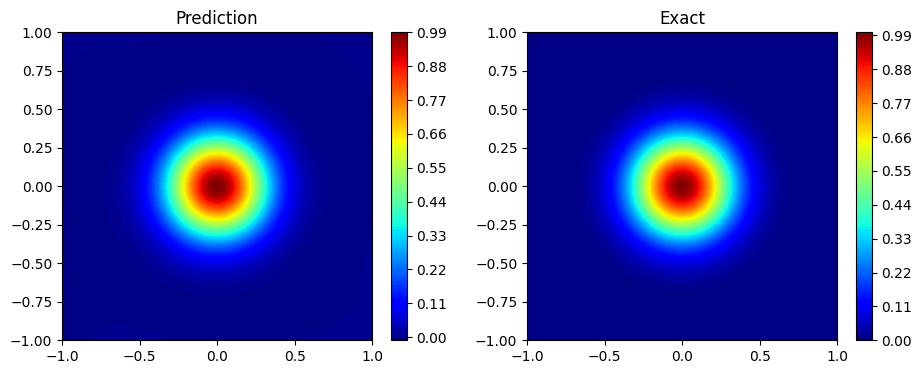

In [76]:
x = torch.linspace(-1, 1, 64).to(device)
y = torch.linspace(-1, 1, 64).to(device)
x, y = torch.meshgrid(x, y)
inputs = torch.cat([x.unsqueeze(-1), y.unsqueeze(-1)], dim=-1)
u_pred = AWAC_model_2D(inputs)
u_exact = u_exact_2d(x, y)

print(f"MSE: {F.mse_loss(u_pred.squeeze(), u_exact)}")

u_pred =u_pred.cpu().detach().numpy().squeeze()
u_exact = u_exact.cpu().detach().numpy()

print(f"MSE: {np.mean((u_pred - u_exact)**2)}")

plt.figure(figsize=(11, 4))
plt.subplot(1, 2, 1)
plt.contourf(x, y, u_pred, levels=100, cmap="jet")
plt.title("Prediction")
plt.colorbar()
plt.subplot(1, 2, 2)
plt.contourf(x, y, u_exact, levels=100, cmap="jet")
plt.title("Exact")
plt.colorbar()
plt.show()

## 3 Dimensions

In [40]:
domaine_3d = [-1,1,-1,1,-1,1]
d = pdeOperator()
device = "cuda" if torch.cuda.is_available() else "cpu"
f_3d = lambda x,y,z : -3 * torch.pi**2 * torch.sin(torch.pi * x) * torch.sin(torch.pi * y) * torch.sin(torch.pi * z)
operator_3d = lambda u,x,y,z : d.laplacian(u , x , y , z)
u_exact_3d = lambda x,y,z : torch.sin(torch.pi * x) * torch.sin(torch.pi * y) * torch.sin(torch.pi * z)

pde_configurations = OperatorConfig(
        operator=operator_3d,
        source_function=f_3d,
        u_exact=u_exact_3d,
        weight= torch.tensor(1 , dtype=torch.float32),
        trainable=False,
        weight_function= lambda x: torch.exp(-x),
        pde_loss = l2_error,
        adaptive_nodes = 0,
        update_rate = 100,
)


coords_3d = [torch.linspace(-1, 1, 32).to(device), torch.linspace(-1, 1, 32).to(device), torch.linspace(-1, 1, 32).to(device)]
u = u_exact_3d(*torch.meshgrid(coords_3d))

TF =False
bcs = [
        BoundaryCondition(
                type=BoundaryType.DIRICHLET,
                location=BoundaryLocation.Z_MIN,
                value= lambda x,y,z : torch.zeros((x.shape[0],x.shape[0])),#u_exact_3d(x , y , z)[0, :, :],
                weight=1,
                trainable=TF,
                weight_function= lambda x: torch.exp(-x),
                ),
        BoundaryCondition(
                type=BoundaryType.DIRICHLET,
                location=BoundaryLocation.Z_MAX,
                value= lambda x,y,z : torch.zeros((x.shape[0],x.shape[0])), # u_exact_3d(x , y , z)[-1, :, :],
                weight=1,
                trainable=TF,
                weight_function= lambda x: torch.exp(-x),
                ),
        BoundaryCondition(
                type=BoundaryType.DIRICHLET,
                location=BoundaryLocation.Y_MIN,
                value= lambda x,y,z :torch.zeros((x.shape[0],x.shape[0])), #u_exact_3d(x , y , z)[:, 0, :],
                weight=1,
                trainable=TF,
                weight_function= lambda x: torch.exp(-x),
                ),
        BoundaryCondition(
                type=BoundaryType.DIRICHLET,
                location=BoundaryLocation.Y_MAX,
                value= lambda x,y,z : torch.zeros((x.shape[0],x.shape[0])), #u_exact_3d(x , y , z)[:, -1, :],
                weight=1,
                trainable=TF,
                weight_function= lambda x: torch.exp(-x),
                ),
        BoundaryCondition(
                type=BoundaryType.DIRICHLET,
                location=BoundaryLocation.X_MIN,
                value= lambda x,y,z : torch.zeros((x.shape[0],x.shape[0])), #u_exact_3d(x , y , z)[:, :, 0],
                weight=1,
                trainable=TF,
                weight_function= lambda x: torch.exp(-x),
                ),
        BoundaryCondition(
                type=BoundaryType.DIRICHLET,
                location=BoundaryLocation.X_MAX,
                value= lambda x,y,z : torch.zeros((x.shape[0],x.shape[0])), #u_exact_3d(x , y , z)[:, :, -1],
                weight=1,
                trainable=TF,
                weight_function= lambda x: torch.exp(-x),
                )
]


In [18]:
u[:, -1, :].shape
torch.mean

<function torch._VariableFunctionsClass.mean>

Training:   0%|          | 0/500 [00:00<?, ?epoch/s]

Training the model...


Training: 100%|██████████| 500/500 [04:18<00:00,  1.93epoch/s, Loss=2.4190e+01, MSE=4.4771e-01]


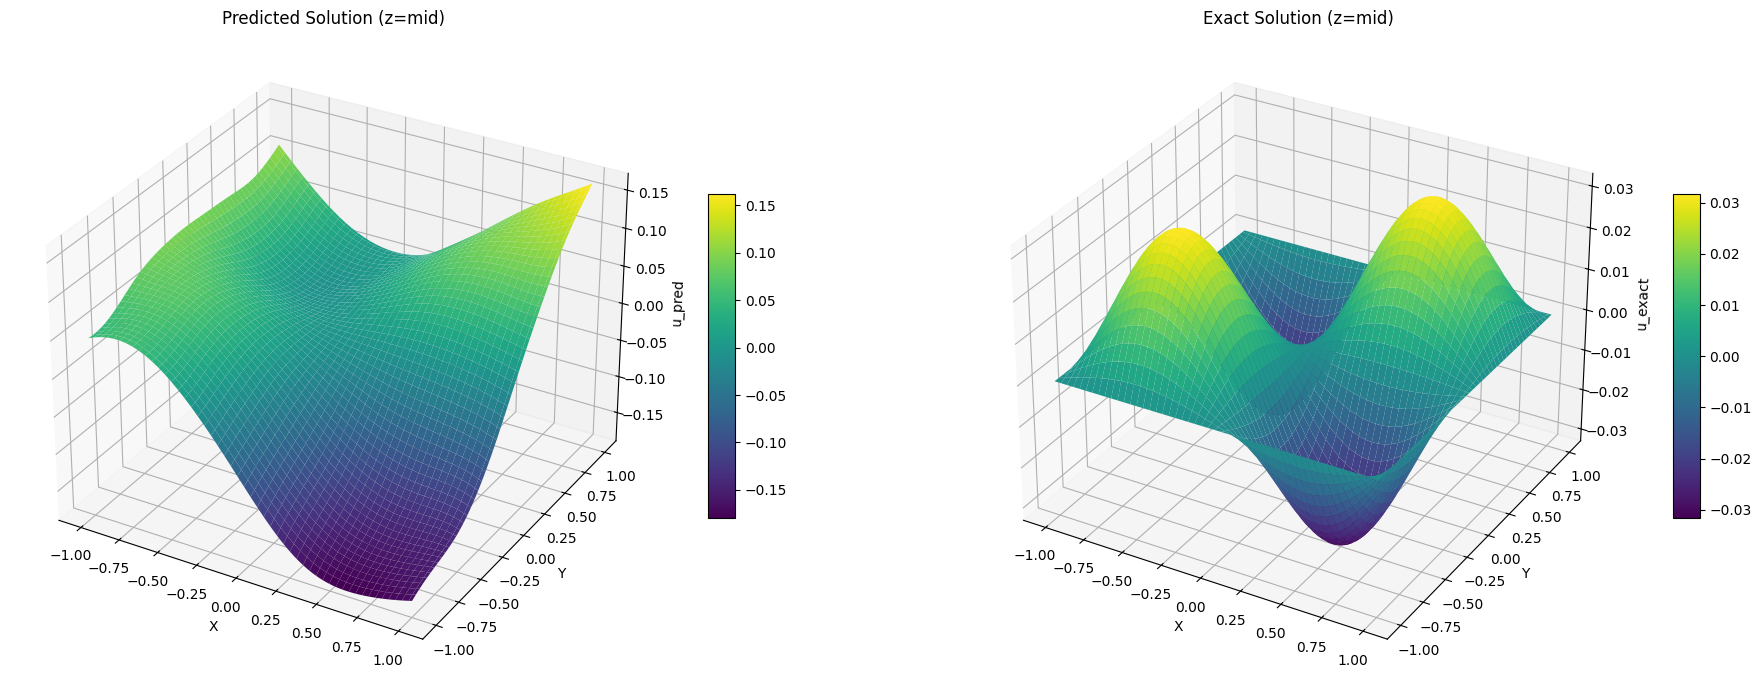

In [41]:
solver = Solver(
        hidden_size=100,
        num_layers=1,
        learning_rate=0.01,
        device=None,
        wandb_logs=False,
        name=None, 
    )
u_pred , mse , loss , coords , risid = solver.solve(dimensions =3 ,
                        coords=coords_3d , 
                        boundary_conditions = bcs,
                        pde_configurations= pde_configurations ,
                        epochs = 500 ,
                        num_test_points = 100)

In [23]:
def benchmarking(epochs = 1000 , lr = 0.01 , update_rate = 100 , update_points = 25):

        domaine_3d = [-1,1,-1,1,-1,1]
        d = pdeOperator()
        device = "cuda" if torch.cuda.is_available() else "cpu"
        f_3d = lambda x,y,z : -3 * torch.pi**2 * torch.sin(torch.pi * x) * torch.sin(torch.pi * y) * torch.sin(torch.pi * z)
        operator_3d = lambda u,x,y,z : d.laplacian(u , x , y , z)
        u_exact_3d = lambda x,y,z : torch.sin(torch.pi * x) * torch.sin(torch.pi * y) * torch.sin(torch.pi * z)
        solver = Solver(
                hidden_size=100,
                num_layers=2,
                learning_rate=lr,
                device=None,
                wandb_logs=False,
                name=None
        )

        congurations = [[False , 0] , [True , 0]  , [False , update_points],[True , update_points] ]
        results = []

        for conf in congurations:

                pde_configurations = OperatorConfig(
                        operator=operator_3d,
                        source_function=f_3d,
                        u_exact=u_exact_3d,
                        weight= torch.tensor(1 , dtype=torch.float32),
                        trainable=conf[0],
                        weight_function= lambda x: torch.exp(-x),
                        pde_loss = F.mse_loss,
                        adaptive_nodes = conf[1],
                        update_rate = update_rate,
                )

                bcs = [
                        BoundaryCondition(
                                type=BoundaryType.DIRICHLET,
                                location=BoundaryLocation.Z_MIN,
                                value= lambda x,y,z : u_exact_3d(x , y , z)[0, :, :],
                                weight=1,
                                trainable=conf[0],
                                weight_function= lambda x: torch.exp(-x),
                                ),
                        BoundaryCondition(
                                type=BoundaryType.DIRICHLET,
                                location=BoundaryLocation.Z_MAX,
                                value= lambda x,y,z : u_exact_3d(x , y , z)[-1, :, :],
                                weight=1,
                                trainable=conf[0],
                                weight_function= lambda x: torch.exp(-x),
                                ),
                        BoundaryCondition(
                                type=BoundaryType.DIRICHLET,
                                location=BoundaryLocation.Y_MIN,
                                value= lambda x,y,z : u_exact_3d(x , y , z)[:, 0, :],
                                weight=1,
                                trainable=conf[0],
                                weight_function= lambda x: torch.exp(-x),
                                ),
                        BoundaryCondition(
                                type=BoundaryType.DIRICHLET,
                                location=BoundaryLocation.Y_MAX,
                                value= lambda x,y,z : u_exact_3d(x , y , z)[:, -1, :],
                                weight=1,
                                trainable=conf[0],
                                weight_function= lambda x: torch.exp(-x),
                                ),
                        BoundaryCondition(
                                type=BoundaryType.DIRICHLET,
                                location=BoundaryLocation.X_MIN,
                                value= lambda x,y,z : u_exact_3d(x , y , z)[:, :, 0],
                                weight=1,
                                trainable=conf[0],
                                weight_function= lambda x: torch.exp(-x),
                                ),
                        BoundaryCondition(
                                type=BoundaryType.DIRICHLET,
                                location=BoundaryLocation.X_MAX,
                                value= lambda x,y,z : u_exact_3d(x , y , z)[:, :, -1],
                                weight=1,
                                trainable=conf[0],
                                weight_function= lambda x: torch.exp(-x),
                                )
                ]

                model , mse , loss , coords  , risid = solver.solve(dimensions = 3 ,
                                                coords = coords_3d ,
                                                boundary_conditions = bcs ,
                                                pde_configurations=pde_configurations,
                                                epochs = epochs ,
                                                plot = False,
                                                )
                
                results.append((model , mse , loss , coords  , risid))

        return results



results = benchmarking(epochs = 500 , lr = 0.001 , update_rate = 50 , update_points = 8)
        

Training:   0%|          | 0/500 [00:00<?, ?epoch/s]

Training the model...


Training:   0%|          | 1/500 [00:00<01:02,  8.03epoch/s, Loss=3.3230e+01, MSE=9.1630e-02]

Training the model...


Training:   0%|          | 1/500 [00:00<00:49,  9.98epoch/s, Loss=3.3260e+01, MSE=9.2948e-02]

Training the model...


Training:   0%|          | 0/500 [00:00<?, ?epoch/s]

Training the model...


Training: 100%|██████████| 500/500 [06:37<00:00,  1.26epoch/s, Loss=8.7684e-02, MSE=7.5276e-03]


Training:   0%|          | 1/500 [00:00<00:54,  9.22epoch/s, Loss=3.5269e+01, MSE=2.8607e-01]
Training the model...
Training: 100%|██████████| 500/500 [00:51<00:00,  9.63epoch/s, Loss=1.2489e-02, MSE=2.3005e-03]
Training:   0%|          | 1/500 [00:00<00:58,  8.60epoch/s, Loss=3.3281e+01, MSE=5.7015e-01]
Training the model...
Training: 100%|██████████| 500/500 [00:53<00:00,  9.29epoch/s, Loss=1.3597e-02, MSE=4.5890e-03]
Training:   0%|          | 1/500 [00:00<00:49, 10.00epoch/s, Loss=3.3253e+01, MSE=3.5780e-01]
Training the model...
Training: 100%|██████████| 500/500 [02:33<00:00,  3.25epoch/s, Loss=1.2534e-02, MSE=2.2903e-03]
Training:   0%|          | 1/500 [00:00<01:05,  7.66epoch/s, Loss=3.3284e+01, MSE=1.2070e+00]
Training the model...
Training: 100%|██████████| 500/500 [02:27<00:00,  3.39epoch/s, Loss=1.0791e-02, MSE=3.9485e-03]

In [89]:
domaine_2d = [-1,1,-1,1]
f_2d = lambda x,y : torch.exp(-10 * (x**2 + y**2))*(-20)*(1-20*x**2) + torch.exp(-10 * (x**2 + y**2))*(-20)*(1-20*y**2)
operator_2d = lambda u,x,y : d.derivation(u, x, order=2) + d.derivation(u, y, order=2)
u_exact_2d = lambda x,y : x**2 + y**2
solver = Solver()

models , models_names = solver.Benchmark(dimensions =2 ,coords= coords_2d , source_function= f_2d , operator= operator_2d , u_exact = u_exact_2d , epochs = 1 , num_points = 20 , n_test = 500 , lr = 0.01, plot = False , layers= 3 , watch = False ,rate = 500)

Starting benchmark for 2D PDE models.
Training PINN ...


Training: 100%|██████████| 1/1 [00:00<00:00,  1.50epoch/s, Loss=37.100921630859375, MSE=0.7250586748123169]


Finished training PINN.
----------------------------------------
Training AC-PINN ...


Training: 100%|██████████| 1/1 [00:00<00:00,  2.59epoch/s, Loss=37.74620056152344, MSE=0.2564839720726013]


Finished training AC-PINN.
----------------------------------------
Training AW-PINN ...


Training: 100%|██████████| 1/1 [00:00<00:00,  1.79epoch/s, Loss=39.08099365234375, MSE=0.20525991916656494]


Finished training AW-PINN.
----------------------------------------
Training ACAW-PINN ...


Training: 100%|██████████| 1/1 [00:00<00:00,  2.46epoch/s, Loss=38.28221893310547, MSE=0.686311662197113]

Finished training ACAW-PINN.
----------------------------------------
Benchmark for 2D completed. Trained models: ['PINN', 'AC-PINN', 'AW-PINN', 'ACAW-PINN']


In [92]:
domaine_3d = [-1,1,-1,1,-1,1]
f_3d = lambda x,y,z : -3 * torch.pi**2 * torch.sin(torch.pi * x) * torch.sin(torch.pi * y) * torch.sin(torch.pi * z)
operator_3d = lambda u,x,y,z : d.derivation(u, x, order=2) + d.derivation(u, y, order=2) + d.derivation(u, z, order=2)
u_exact_3d = lambda x,y,z : torch.sin(torch.pi * x) * torch.sin(torch.pi * y) * torch.sin(torch.pi * z)

models, modles_names = solver.Benchmark(dimensions =3 ,coords= coords_3d, source_function= f_3d , operator= operator_3d , u_exact = u_exact_3d , epochs = 1 , num_points = 10 , n_test = 100 , lr = 0.01, plot = False , layers= 3 , watch = False , rate = 1)

Starting benchmark for 3D PDE models.
Training PINN ...


Training: 100%|██████████| 1/1 [00:00<00:00, 19.06epoch/s, Loss=79.8757553100586, MSE=0.5653858184814453]


Finished training PINN.
----------------------------------------
Training AC-PINN ...


Training: 100%|██████████| 1/1 [00:00<00:00, 10.60epoch/s, Loss=79.89942169189453, MSE=0.6605468392372131]


Finished training AC-PINN.
----------------------------------------
Training AW-PINN ...


Training: 100%|██████████| 1/1 [00:00<00:00, 16.30epoch/s, Loss=79.88895416259766, MSE=0.5240010619163513]


Finished training AW-PINN.
----------------------------------------
Training ACAW-PINN ...


Training: 100%|██████████| 1/1 [00:00<00:00,  4.86epoch/s, Loss=79.87728881835938, MSE=0.18896910548210144]

Finished training ACAW-PINN.
----------------------------------------
Benchmark for 3D completed. Trained models: ['PINN', 'AC-PINN', 'AW-PINN', 'ACAW-PINN']
